In [1]:
from sqlalchemy.engine import create_engine
import pandas as pd
from tqdm import tqdm

In [2]:
# 替换为你的 Hive 连接信息
hive_username = '*********'
hive_server = '************'
hive_port = 10000
hive_database = 'default'  # 如果有特定数据库，替换为相应的数据库名称

In [3]:
# 创建 Hive 连接引擎
engine = create_engine(f'hive://{hive_username}@{hive_server}:{hive_port}/{hive_database}')
# 使用 pandas 从 Hive 中读取数据
query = '************8'
# 使用 pandas.read_sql_query 并在查询结果大于一定数量时显示进度条
def progress_sql(query, con, chunksize=1000):
    # 初始化空的 DataFrame
    df_list = []
    # 获取数据并显示进度条
    for chunk in tqdm(pd.read_sql_query(query, con, chunksize=chunksize), desc="Fetching data"):
        df_list.append(chunk)
    # 合并所有块
    return pd.concat(df_list, ignore_index=True)
# 调用 progress_sql 函数
data = progress_sql(query, engine)


Fetching data: 5117it [04:44, 17.98it/s]


In [4]:
# 观察数据集
data.head()

,user_id,create_day,platform,country_code,postal_code,lat_lon,app_version,match_reason,is_match,is_merge,...,os_version,timezone_abbreviation,hourid,device_type,_col28,webkit_version,build_version,first_install,utm_source,target
0,24037938.0,2024-05-15,1.0,US,38126,"35.1274,-90.0403",1.8.1,6.0,1.0,2.0,...,14,GMT-04:00,00,Android,14,537.36,UP1A,1.0,FB,1.0
1,24220445.0,2024-05-17,2.0,CL,None,"-33.4521,-70.6536",1.8.1,1.0,1.0,2.0,...,17.4.1,CLT,17,iPhone,17_4_1,605.1.15,15E148,1.0,FB,1.0
2,24580766.0,2024-05-19,1.0,TH,30000,"15.0598,102.2215",1.8.1,5.0,1.0,2.0,...,12,GMT+07:00,23,Android,12,537.36,SP1A,1.0,FB,0.0
3,26607629.0,2024-05-27,2.0,CL,None,"-36.8206,-71.9663",1.8.2,1.0,1.0,2.0,...,17.4.1,CLT,22,iPhone,17_4_1,605.1.15,15E148,1.0,FB,1.0
4,25600887.0,2024-05-23,1.0,US,30301,"33.7485,-84.3871",1.8.1,10.0,1.0,2.0,...,12,EDT,20,Android,12,537.36,SP1A,1.0,FB,1.0


In [5]:
# Step 1: Data Cleaning

# 1. Handle missing values
data_cleaned = data.fillna({
    'postal_code': 'Unknown',
    'lat_lon': '0,0',
    'app_version': 'Unknown',
    'match_reason': 0,
    'is_match': 0,
    'is_merge': 0,
    'is_stat_report': 0,
    'public_ip': '0.0.0.0',
    'intranet_ip': '0.0.0.0',
    'ip_source': 'Unknown',
    'naturally_install': 0,
    'device_timezone': 'Unknown',
    'carrier': 'Unknown',
    'cpu_cores': 0,
    'external_storage_size': 0.0,
    'free_space_in_external_storage_size': 0.0,
    'device_model_name': 'Unknown',
    'screen_width': 0,
    'screen_height': 0,
    'screen_density': 0.0,
    'os_version': 'Unknown',
    'timezone_abbreviation': 'Unknown',
    'hourid': 0,
    'device_type': 'Unknown',
    '_col28': 'Unknown',
    'webkit_version': 'Unknown',
    'build_version': 'Unknown',
    'first_install': 0,
    'utm_source': 'Unknown'
})

# 2. Remove duplicate records
data_cleaned = data_cleaned.drop_duplicates()

# 3. Split latitude and longitude into separate columns
data_cleaned[['latitude', 'longitude']] = data_cleaned['lat_lon'].str.split(',', expand=True)
data_cleaned['latitude'] = pd.to_numeric(data_cleaned['latitude'], errors='coerce').fillna(0)
data_cleaned['longitude'] = pd.to_numeric(data_cleaned['longitude'], errors='coerce').fillna(0)

# Drop the original 'lat_lon' column
data_cleaned = data_cleaned.drop(columns=['lat_lon'])

# Display the cleaned data
data_cleaned.head()


,user_id,create_day,platform,country_code,postal_code,app_version,match_reason,is_match,is_merge,is_stat_report,...,hourid,device_type,_col28,webkit_version,build_version,first_install,utm_source,target,latitude,longitude
0,24037938.0,2024-05-15,1.0,US,38126,1.8.1,6.0,1.0,2.0,1.0,...,00,Android,14,537.36,UP1A,1.0,FB,1.0,35.1274,-90.0403
1,24220445.0,2024-05-17,2.0,CL,Unknown,1.8.1,1.0,1.0,2.0,1.0,...,17,iPhone,17_4_1,605.1.15,15E148,1.0,FB,1.0,-33.4521,-70.6536
2,24580766.0,2024-05-19,1.0,TH,30000,1.8.1,5.0,1.0,2.0,1.0,...,23,Android,12,537.36,SP1A,1.0,FB,0.0,15.0598,102.2215
3,26607629.0,2024-05-27,2.0,CL,Unknown,1.8.2,1.0,1.0,2.0,1.0,...,22,iPhone,17_4_1,605.1.15,15E148,1.0,FB,1.0,-36.8206,-71.9663
4,25600887.0,2024-05-23,1.0,US,30301,1.8.1,10.0,1.0,2.0,1.0,...,20,Android,12,537.36,SP1A,1.0,FB,1.0,33.7485,-84.3871


In [6]:
from sklearn.preprocessing import LabelEncoder

# List of columns to encode
columns_to_encode = ['country_code', 'postal_code', 'app_version', 'public_ip', 
                     'intranet_ip', 'ip_source', 'device_timezone', 'carrier',
                     'device_model_name', 'os_version', 'timezone_abbreviation', 
                     'device_type', '_col28', 'webkit_version', 'build_version', 
                     'utm_source']

# Initialize LabelEncoder
label_encoders = {col: LabelEncoder() for col in columns_to_encode}

# Encode the columns
for col in columns_to_encode:
    data_cleaned[col] = label_encoders[col].fit_transform(data_cleaned[col])

# Convert columns to appropriate data types if necessary
data_cleaned = data_cleaned.apply(pd.to_numeric, errors='ignore')

# Display the cleaned and encoded data
data_cleaned.head()


,user_id,create_day,platform,country_code,postal_code,app_version,match_reason,is_match,is_merge,is_stat_report,...,hourid,device_type,_col28,webkit_version,build_version,first_install,utm_source,target,latitude,longitude
0,24037938.0,2024-05-15,1.0,250,17897,31,6.0,1.0,2.0,1.0,...,00,5,42,3,1221,1.0,2,1.0,35.1274,-90.0403
1,24220445.0,2024-05-17,2.0,73,47477,31,1.0,1.0,2.0,1.0,...,17,8,126,4,6,1.0,2,1.0,-33.4521,-70.6536
2,24580766.0,2024-05-19,1.0,236,13297,31,5.0,1.0,2.0,1.0,...,23,5,9,3,1052,1.0,2,0.0,15.0598,102.2215
3,26607629.0,2024-05-27,2.0,73,47477,32,1.0,1.0,2.0,1.0,...,22,8,126,4,6,1.0,2,1.0,-36.8206,-71.9663
4,25600887.0,2024-05-23,1.0,250,13563,31,10.0,1.0,2.0,1.0,...,20,5,9,3,1052,1.0,2,1.0,33.7485,-84.3871


In [7]:
df = data_cleaned.drop(columns=['user_id', 'create_day'])



In [14]:
import pandas as pd
import scorecardpy as sc
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split

# 假设 df 是一个 pandas DataFrame，并确保 'target' 列存在
if 'target' not in df.columns:
    raise KeyError("'target' 列未找到在 DataFrame 中")

# 确保 target 列的值只有 0 和 1
df['target'] = df['target'].apply(lambda x: 1 if x == 1 else 0)

# 1. 变量筛选
def var_filter(df, target_col):
    # 删除缺失值超过 50% 的列
    df_filtered = df.dropna(thresh=len(df) * 0.5, axis=1)
    # 删除 target 列中带有缺失值的行
    df_filtered = df_filtered.dropna(subset=[target_col])
    return df_filtered

dt_f = var_filter(df, "target")
print(dt_f.shape)

# 将除了'target'字段以外的所有字段转换为数字形式，并将空值替换为-999
for col in dt_f.columns:
    if col != 'target':
        dt_f[col] = pd.to_numeric(dt_f[col], errors='coerce').fillna(-999)

print(dt_f.dtypes)


(4550398, 33)
platform                               float64
country_code                             int64
postal_code                              int64
app_version                              int64
match_reason                           float64
is_match                               float64
is_merge                               float64
is_stat_report                         float64
public_ip                                int64
intranet_ip                              int64
ip_source                                int64
naturally_install                      float64
device_timezone                          int64
carrier                                  int64
cpu_cores                              float64
external_storage_size                  float64
free_space_in_external_storage_size    float64
device_model_name                        int64
screen_width                           float64
screen_height                          float64
screen_density                         float64

In [15]:
# 2. 数据集拆分
def split_df(df, target_col, test_size=0.3, random_state=42):
    X = df.drop(columns=[target_col])
    y = df[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return {
        "train": pd.concat([X_train, y_train], axis=1),
        "test": pd.concat([X_test, y_test], axis=1)
    }

dt_list = split_df(dt_f, "target")
print(type(dt_list))

<class 'dict'>


In [16]:
# 提取标签
label_list = {key: value["target"] for key, value in dt_list.items()}

In [17]:
# 决策树分箱
# 确保数据集中包含 'target' 列
print(dt_list["train"].columns)  # 打印列名以确保 'target' 列存在


Index(['platform', 'country_code', 'postal_code', 'app_version',
       'match_reason', 'is_match', 'is_merge', 'is_stat_report', 'public_ip',
       'intranet_ip', 'ip_source', 'naturally_install', 'device_timezone',
       'carrier', 'cpu_cores', 'external_storage_size',
       'free_space_in_external_storage_size', 'device_model_name',
       'screen_width', 'screen_height', 'screen_density', 'os_version',
       'timezone_abbreviation', 'hourid', 'device_type', '_col28',
       'webkit_version', 'build_version', 'first_install', 'utm_source',
       'latitude', 'longitude', 'target'],
      dtype='object')


In [18]:
# 决策树分箱
bins2_tree = sc.woebin(dt_list["train"], y="target", method="tree")
dt_woe_list = {key: sc.woebin_ply(value, bins2_tree) for key, value in dt_list.items()}
bins2_woe = pd.concat(bins2_tree.values())

[INFO] creating woe binning ...
Binning on 3185278 rows and 33 columns in 00:08:14
[INFO] converting into woe values ...
Woe transformating on 3185278 rows and 32 columns in 00:07:29
[INFO] converting into woe values ...
Woe transformating on 1365120 rows and 32 columns in 00:02:36


In [19]:
# 建立逻辑回归模型，并且逐步回归法迭代
X_train_woe = dt_woe_list["train"].drop(columns=["target"])
y_train_woe = dt_woe_list["train"]["target"]

m1 = LogisticRegression(max_iter=1000)
rfecv = RFECV(estimator=m1, step=1, cv=5, scoring='accuracy')
rfecv.fit(X_train_woe, y_train_woe)

selected_features = X_train_woe.columns[rfecv.support_]
m2 = LogisticRegression(max_iter=1000)
m2.fit(X_train_woe[selected_features], y_train_woe)

LogisticRegression(max_iter=1000)

In [22]:
# 对所有用户打分，基础分600，权重50
scorecard = sc.scorecard(bins2_tree, model=m2, xcolumns=selected_features, points0=600, odds0=50)
df_score = sc.scorecard_ply(dt_f, scorecard)

/usr/local/lib/python3.8/dist-packages/scorecardpy/scorecard.py:353: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat_score.loc[:,'score'] = card_basepoints + dat_score.sum(axis=1)


In [23]:
# 将分数加入到原数据中
dt_f['score'] = df_score['score']

In [24]:
# 输出最终的数据
dt_f.to_csv('**********/scored_data.csv', index=False)

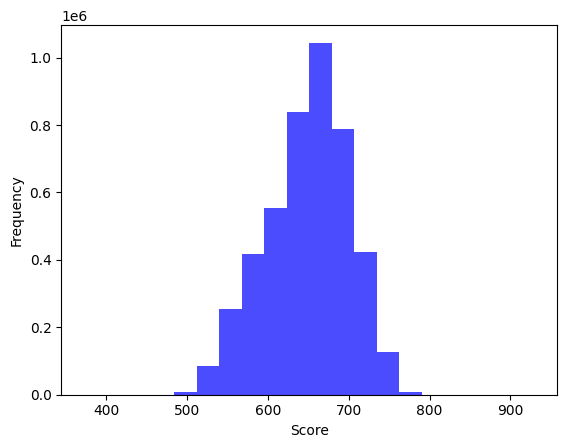

In [26]:
import matplotlib.pyplot as plt

# 绘制分数分布直方图
plt.hist(df_score['score'], bins=20, color='blue', alpha=0.7)
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()  # 显示绘制的图形


In [46]:
# 调用 scorecard 函数
score = sc.scorecard(bins2_tree, model=m2, xcolumns=selected_features, points0=600, odds0=50)

# 打印 score 对象以查看其结构
print(type(score))

# 将字典转换为 DataFrame
bins_germ_woe = pd.DataFrame(list(score.items()), columns=['variable', 'bin_points'])

# 打印 bins_germ_woe
print(bins_germ_woe)



<class 'dict'>
                 variable                                         bin_points
0              basepoints       variable  bin  points
0  basepoints  NaN ...
1       naturally_install              variable         bin  points
0  na...
2          webkit_version           variable         bin  points
2  webki...
3            country_code         variable            bin  points
4  coun...
4                is_match      variable         bin  points
15  is_match ...
5              os_version        variable            bin  points
21  os_v...
6                  hourid     variable          bin  points
26   hourid  ...
7                platform      variable         bin  points
34  platform ...
8   external_storage_size                   variable            bin  poin...
9   timezone_abbreviation                   variable          bin  points...
10               is_merge      variable         bin  points
86  is_merge ...
11              cpu_cores       variable         bin  points


In [47]:
# 保存 DataFrame 到 CSV 文件
bins_germ_woe.to_csv('**********/bins_germ_woe.csv', index=False)


In [51]:

# 假设 data 是原始数据
# data = progress_sql(query, engine)

# 定义需要编码的字段
columns_to_encode = ['country_code', 'postal_code', 'app_version', 'public_ip', 
                     'intranet_ip', 'ip_source', 'device_timezone', 'carrier',
                     'device_model_name', 'os_version', 'timezone_abbreviation', 
                     'device_type', '_col28', 'webkit_version', 'build_version', 
                     'utm_source']

# 初始化 LabelEncoder 对象
label_encoders = {col: LabelEncoder() for col in columns_to_encode}

# 编码字段
for col in columns_to_encode:
    data[col] = label_encoders[col].fit_transform(data[col])

# 创建字典存储映射关系
encoding_mapping = {}

# 循环每个编码的字段
for col in columns_to_encode:
    # 获取该字段的 LabelEncoder
    encoder = label_encoders[col]
    
    # 创建存储该字段映射关系的字典
    col_mapping = {}
    
    # 循环每个唯一值
    for i, value in enumerate(encoder.classes_):
        # 将编码值映射到原始字符串值
        col_mapping[i] = value
    
    # 将该字段的映射关系添加到 encoding_mapping 字典中
    encoding_mapping[col] = col_mapping

# 将int64类型的值转换为Python内置的int类型
def convert(o):
    if isinstance(o, np.int64): 
        return int(o)
    raise TypeError

# 将映射关系保存为JSON文件
with open('**********/encoding_mapping.json', 'w') as f:
    json.dump(encoding_mapping, f, default=convert, indent=4)

print("编码映射关系已保存到 encoding_mapping.json 文件中。")


Fetching data: 5117it [04:55, 17.34it/s]


编码映射关系已保存到 encoding_mapping.json 文件中。
